# Building and testing a neural network

In [2]:
## imports
import LHEImport.LHEImport as li
import numpy as np
import pandas as pd
import gc

In [53]:
## plotting imports
import matplotlib.pyplot as plt
import mplhep as hep
### plt styles

plt.style.use([hep.style.CMS])
plt.rcParams.update({"figure.figsize":[12,12], "font.size":11, "figure.titlesize":11, "axes.titlesize":11})
hep.style.use({"font.size":16})

## Importing data
First we import the data. 

The current data set is a result of 1mil events generated in 100k batches in MadGraph. 

In [4]:
raw_data = pd.read_hdf('./big.h5', key='all')

Extracting the weight information. Weights correspond to specific coefficient choices, just do this for a single lhe file here as we know that these coefficients are the same across each of the datasets generated.

In [5]:
weight_dict = li.gen_weight_dict('./mil_lhe_files/run_1.lhe')

For each label (e.g. 'rwgt_22'), there is a coefficient:value dict. An example:

In [6]:
print(weight_dict['rwgt_22'])

{'16': '2.0'}


Here we see that the CtG coefficient (16) has to a value of $\approx -0.105$ in the 'rwgt_12' dataset.

## Weights
Now we need to extract the weights. Here we form a DataFrame with all the weights and their corresponding label. 

In [7]:
def create_weight_df(keys, weights):
    def getWeights(weightId, weightCol):
        return np.array([d.get(weightId) for d in weightCol])
    df = pd.DataFrame()
    for key in keys:
        df[f'{key}'] = getWeights(key, weights)
    return df

In [8]:
weights = create_weight_df(weight_dict.keys(), raw_data.weights) 

In [9]:
# weights.head()

## Sampling the dataset

We don't want to use 1mil events for various reasons so we need to sample the dataset.

We can use the unweighting method to do this:

In [10]:
sm_sample = li.getSample(raw_data, 200000, weights['rwgt_1'])

In [11]:
eft_sample = li.getSample(raw_data, 200000, weights['rwgt_22'])

In [12]:
eft_sample.head()

,weights,pt_z,eta_z,deltaphi_ll_Z,pt_t,eta_t,pt_tbar,eta_tbar,dR_t_z,cosstar
45667,"{'rwgt_1': 0.01764135, 'rwgt_2': 0.01764135, '...",158.212451,0.920665,-0.498748,517.594887,0.291727,None,None,3.495885,0.996644
85212,"{'rwgt_1': 0.017651961, 'rwgt_2': 0.017651961,...",218.176054,-2.129726,0.452144,161.772096,-1.389989,None,None,1.549081,0.999938
89987,"{'rwgt_1': 0.01762656, 'rwgt_2': 0.01762656, '...",22.279356,-2.724381,3.109973,118.371294,2.368745,None,None,5.400472,0.955521
35466,"{'rwgt_1': 0.017654352, 'rwgt_2': 0.017654352,...",280.919384,0.387531,0.061227,343.642098,0.367140,None,None,1.285920,0.999783
2714,"{'rwgt_1': 0.017651961, 'rwgt_2': 0.017651961,...",226.314580,2.288017,0.018497,172.879652,-2.066457,None,None,4.520444,0.999988


### Verifying plots
Here we plot $p_{\mathrm{T}}(\text{Z})$, $p_{\mathrm{T}}(\text{t})$, and $\eta(Z)$ with SM data and the eft fit.

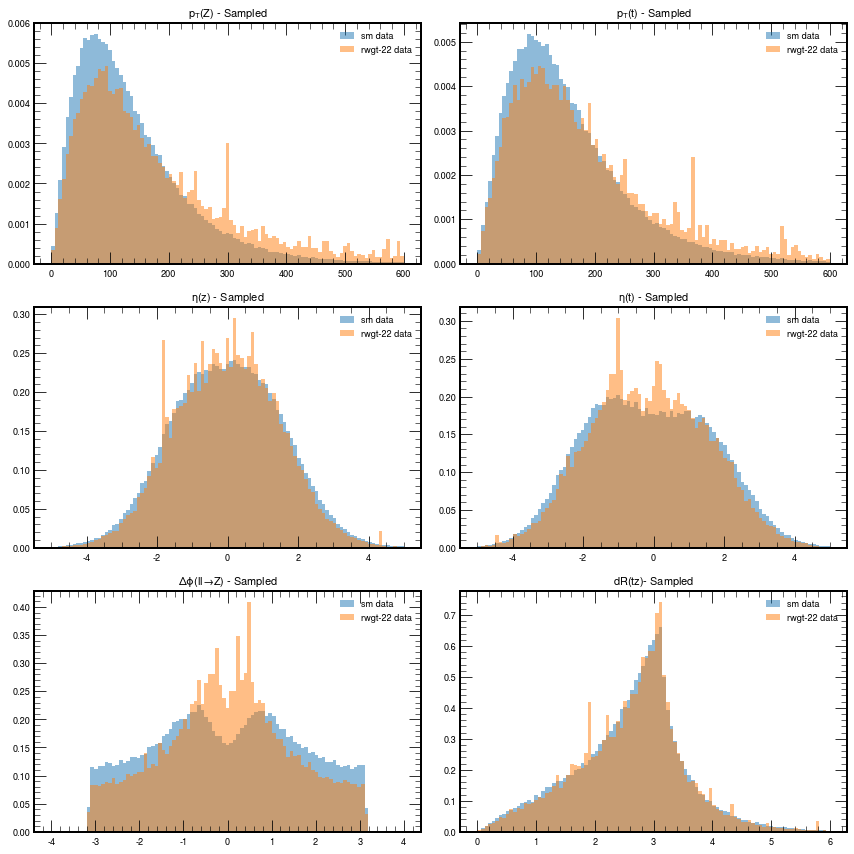

In [13]:
bins_pt = np.linspace(0,600, 100)
bins_eta = np.linspace(-5,5,100)
bins_llz = np.linspace(-4,4,100)
bins_star = np.linspace(-0,6,100)
fig, axes = plt.subplots(3,2)
axes[0][0].hist(sm_sample['pt_z'], bins=bins_pt, density=True, alpha=0.5, label='sm data')
axes[0][0].hist(eft_sample['pt_z'], bins=bins_pt, density=True, alpha=0.5, label='rwgt-22 data')
axes[0][0].set_title("$p_T(Z)$ - Sampled")
axes[0][0].legend()
axes[0][1].hist(sm_sample['pt_t'], bins=bins_pt, density=True, alpha=0.5, label='sm data')
axes[0][1].hist(eft_sample['pt_t'], bins=bins_pt, density=True, alpha=0.5, label='rwgt-22 data')
axes[0][1].set_title("$p_T(t)$ - Sampled")
axes[0][1].legend()
axes[1][0].hist(sm_sample['eta_z'], bins=bins_eta, density=True, alpha=0.5, label='sm data')
axes[1][0].hist(eft_sample['eta_z'], bins=bins_eta, density=True, alpha=0.5, label='rwgt-22 data')
axes[1][0].set_title("$\eta(z)$ - Sampled")
axes[1][0].legend()
axes[1][1].hist(sm_sample['eta_t'], bins=bins_eta, density=True, alpha=0.5, label='sm data')
axes[1][1].hist(eft_sample['eta_t'], bins=bins_eta, density=True, alpha=0.5, label='rwgt-22 data')
axes[1][1].set_title("$\eta(t)$ - Sampled")
axes[1][1].legend()
axes[2][0].hist(sm_sample['deltaphi_ll_Z'], bins=bins_llz, density=True, alpha=0.5, label='sm data')
axes[2][0].hist(eft_sample['deltaphi_ll_Z'], bins=bins_llz, density=True, alpha=0.5, label='rwgt-22 data')
axes[2][0].set_title("$\Delta \phi(ll \\to Z)$ - Sampled")
axes[2][0].legend()
axes[2][1].hist(sm_sample['dR_t_z'], bins=bins_star, density=True, alpha=0.5, label='sm data')
axes[2][1].hist(eft_sample['dR_t_z'], bins=bins_star, density=True, alpha=0.5, label='rwgt-22 data')
axes[2][1].set_title("$ \mathrm{d}R(\mathrm{tz})$- Sampled")
axes[2][1].legend()
plt.tight_layout()
plt.show()

# Neural network
Now we're going to construct the neural network.

The first step will be to process the data, that way we can provide correctly weighted and formatted data to the DNN so that it can do the best job possible. 

After this processing step, the next step will be to construct the neural network. Here there are a number of different variables at play, so now we have to experiment to find the optimal settings for maximum accuracy with the DNN. 

## Processing

Here we will process the data, ready for training the neural network.

The first network that we'll be building is a binary classifier. This will be able to distinguish between an EFT dataset and non(SM)-datasets. The target is EFT, so we assign an integer value of 1 to all the EFT datasets. 

In [14]:
ones = np.ones(len(eft_sample))
zeros = np.zeros(len(sm_sample))

In [15]:
eft_sample = eft_sample.assign(target=pd.Series(ones).values)
sm_sample = sm_sample.assign(target=pd.Series(zeros).values)
# eft_sample['target'] = ones
# sm_sample['target'] = zeros

In [16]:
print(eft_sample.target.head(1))
print(sm_sample.target.head(1))

45667    1.0
Name: target, dtype: float64
20464    0.0
Name: target, dtype: float64


So now we see have appropriate targets applied, we need to combine the two sets into a single dataframe. 

In [31]:
dataset = pd.concat([eft_sample, sm_sample])

In [18]:
dataset.to_hdf('samples.h5', key='all')

/home/craig/.local/lib/python3.10/site-packages/pandas/core/generic.py:2703: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_values] [items->Index(['weights', 'pt_tbar', 'eta_tbar'], dtype='object')]

  pytables.to_hdf(


In [19]:
data_len = len(dataset)
print(f"Dataset has size: {data_len}")
# dataset.head()

Dataset has size: 400000


We see that there are now 400k entries in our dataframe. 

If we look at the dataframe we can see that there are a few columns that contain only N/A values, so we can remove them. We can also drop the weights from our dataframe. 

In [20]:
dataset = dataset.dropna(how='all',axis=1)

In [21]:
dataset = dataset.drop('weights', axis=1)

In [22]:
# dataset.head()

We now split the data into inputs, $X$, and outputs, $y$:

In [23]:
X = dataset
y = X.pop('target')
# y

To optimise for training, we now need to standardise the datasets. We can see that some of the variables range from 0 to 1000 and others from 0.8 to 0.9. To do this there are number of built in functions in scikit that allow for this. 

Preprocessing documentation is found on the [scikit website](https://scikit-learn.org/stable/modules/preprocessing.html). 

### StandardScaler

In [24]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler, QuantileTransformer, Normalizer

In [25]:
scaler = StandardScaler().fit(X)
mm_scaler = MinMaxScaler().fit(X)
mas_scaler = MaxAbsScaler().fit(X)
qt_scaler = QuantileTransformer(output_distribution='normal').fit(X)
norm_scaler = Normalizer().fit(X)

In [26]:
X_scaled = scaler.transform(X)
X_mm = mm_scaler.transform(X)
X_mas = mas_scaler.transform(X)
X_qt = qt_scaler.transform(X)
X_norm = norm_scaler.transform(X)

In [27]:
df_scaled = pd.DataFrame(X_scaled)
df_mm = pd.DataFrame(X_mm)
df_mas = pd.DataFrame(X_mas)
df_qt = pd.DataFrame(X_qt)
df_norm = pd.DataFrame(X_norm)
df_scaled.head()

,0,1,2,3,4,5,6
0,-0.053215,0.613377,-0.318556,2.573381,0.245334,0.924129,0.269390
1,0.374286,-1.393485,0.290573,-0.106217,-0.729644,-1.132556,0.287021
2,-1.022328,-1.784710,1.993141,-0.433056,1.449489,2.936213,0.049282
3,0.821605,0.262626,0.040156,1.263393,0.289055,-1.410570,0.286192
4,0.432308,1.512962,0.012785,-0.022569,-1.121828,2.006515,0.287290


In [28]:
df_scaled = df_scaled.assign(target=pd.Series(y).values)
df_mm = df_mm.assign(target=pd.Series(y).values)
df_mas = df_mas.assign(target=pd.Series(y).values)
df_qt = df_qt.assign(target=pd.Series(y).values)
df_norm = df_norm.assign(target=pd.Series(y).values)
df_scaled.head()

,0,1,2,3,4,5,6,target
0,-0.053215,0.613377,-0.318556,2.573381,0.245334,0.924129,0.269390,1.0
1,0.374286,-1.393485,0.290573,-0.106217,-0.729644,-1.132556,0.287021,1.0
2,-1.022328,-1.784710,1.993141,-0.433056,1.449489,2.936213,0.049282,1.0
3,0.821605,0.262626,0.040156,1.263393,0.289055,-1.410570,0.286192,1.0
4,0.432308,1.512962,0.012785,-0.022569,-1.121828,2.006515,0.287290,1.0


In [32]:
dataset.loc[dataset['target']==1].mean()

/tmp/ipykernel_2946/550069992.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  dataset.loc[dataset['target']==1].mean()


pt_z             194.033432
eta_z             -0.019020
deltaphi_ll_Z      0.000347
pt_t             194.319617
eta_t             -0.137758
pt_tbar                 NaN
eta_tbar                NaN
dR_t_z             2.627574
cosstar            0.954095
target             1.000000
dtype: float64

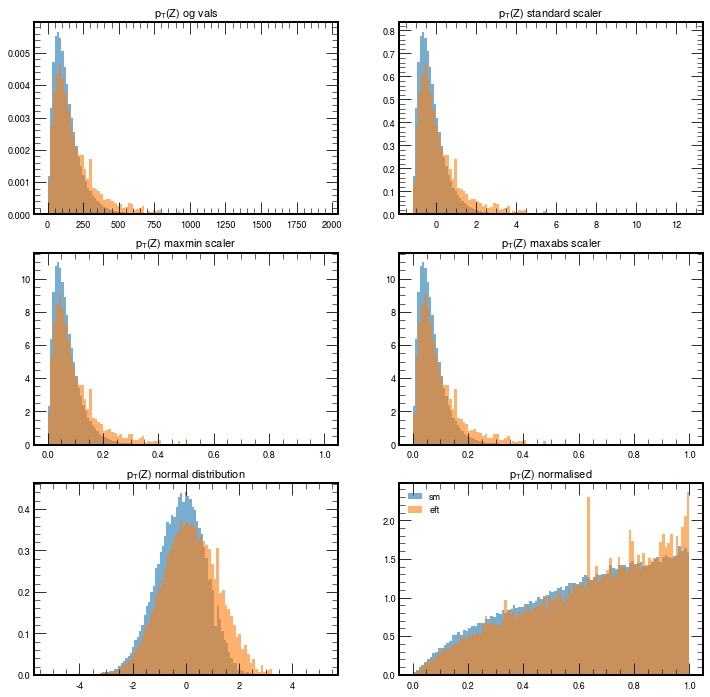

In [33]:
bins_1 = np.linspace(-4,4,100)
bins=np.linspace(0,600,100)
bins_abs=np.linspace(-0.5,0.5,100)
fig, ax = plt.subplots(3,2)
ax[0][0].hist(dataset.loc[dataset['target']!=1.0]['pt_z'], bins=100, alpha=0.6, density=True)
ax[0][0].hist(dataset.loc[dataset['target']==1.0]['pt_z'], bins=100, alpha=0.6, density=True)
ax[0][0].set_title('$p_\mathrm{T}(Z)$ og vals')
ax[0][1].hist(df_scaled.loc[df_scaled['target']!=1.0][0], bins=100, alpha=0.6, density=True)
ax[0][1].hist(df_scaled.loc[df_scaled['target']==1.0][0], bins=100, alpha=0.6, density=True)
ax[0][1].set_title('$p_\mathrm{T}(Z)$ standard scaler')
ax[1][0].hist(df_mm.loc[df_mm['target']!=1.0][0], bins=100, alpha=0.6, density=True)
ax[1][0].hist(df_mm.loc[df_mm['target']==1.0][0], bins=100, alpha=0.6, density=True)
ax[1][0].set_title('$p_\mathrm{T}(Z)$ maxmin scaler')
ax[1][1].hist(df_mas.loc[df_mas['target']!=1.0][0], bins=100, alpha=0.6, density=True, label='sm')
ax[1][1].hist(df_mas.loc[df_mas['target']==1.0][0], bins=100, alpha=0.6, density=True, label='eft')
ax[1][1].set_title('$p_\mathrm{T}(Z)$ maxabs scaler')
ax[2][0].hist(df_qt.loc[df_qt['target']!=1.0][0], bins=100, alpha=0.6, density=True, label='sm')
ax[2][0].hist(df_qt.loc[df_qt['target']==1.0][0], bins=100, alpha=0.6, density=True, label='eft')
ax[2][0].set_title('$p_\mathrm{T}(Z)$ normal distribution')
ax[2][1].hist(df_norm.loc[df_norm['target']!=1.0][0], bins=100, alpha=0.6, density=True, label='sm')
ax[2][1].hist(df_norm.loc[df_norm['target']==1.0][0], bins=100, alpha=0.6, density=True, label='eft')
ax[2][1].set_title('$p_\mathrm{T}(Z)$ normalised')
plt.legend()
plt.show()


I'm gonna choose that last one that makes everything gaussian.

### Training models

From research into neural networks, it's advised that for numerical values it's beneficial 

In [34]:
X = df_mm
y = X.pop('target')

In [35]:
from sklearn.model_selection import train_test_split

In [36]:
train_X, val_X, train_y, val_y = train_test_split(X, y, test_size=0.2)

In [37]:
from tensorflow import keras
from tensorflow.keras import layers

2022-02-14 12:01:44.214802: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib/:/home/craig/.local/lib/:/home/craig/Downloads/MG5_aMC_v3_2_0/HEPTools/lhapdf6_py3/lib/
2022-02-14 12:01:44.214820: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [38]:
input_shape = [train_X.shape[1]]

## Testing number of layers

In [95]:
model1 = keras.Sequential([
    # layers.BatchNormalization(input_shape=input_shape),
    layers.Dense(256, activation='relu', input_shape=input_shape),
    # layers.BatchNormalization(),
    # layers.Dropout(0.1),
    layers.Dense(256, activation='relu'),
    layers.Dense(256, activation='relu'),
    # layers.BatchNormalization(),
    # layers.Dropout(0.1),
    layers.Dense(1, activation='sigmoid')
])
model1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_accuracy'])

early_stopping=keras.callbacks.EarlyStopping(
    patience=40,
    min_delta=0.01,
    restore_best_weights=True,
)
history1 = model1.fit(train_X,train_y,validation_data=(val_X, val_y), batch_size=256, epochs=200, callbacks=[early_stopping], verbose=0, use_multiprocessing=True )
history_df1 = pd.DataFrame(history1.history)
history_df1.head()


model1.save('./models/3layer.h5')

,loss,binary_accuracy,val_loss,val_binary_accuracy
0,0.668855,0.575316,0.667006,0.579638
1,0.665464,0.581647,0.666969,0.582175
2,0.663674,0.583641,0.663542,0.583325
3,0.662625,0.584519,0.663888,0.584162
4,0.661752,0.585084,0.664354,0.581438


In [146]:
model1 = keras.models.load_model('./models/3layer.h5')

In [96]:
model2 = keras.Sequential([
    # layers.BatchNormalization(input_shape=input_shape),
    layers.Dense(256, activation='relu', input_shape=input_shape),
    layers.Dense(256, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])
model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_accuracy'])

early_stopping=keras.callbacks.EarlyStopping(
    patience=40,
    min_delta=0.01,
    restore_best_weights=True,
)
history2 = model2.fit(train_X,train_y,validation_data=(val_X, val_y), batch_size=256, epochs=200, callbacks=[early_stopping], verbose=0, use_multiprocessing=True )
history_df2 = pd.DataFrame(history2.history)
history_df2.head()

model2.save('./models/2layer.h5')

,loss,binary_accuracy,val_loss,val_binary_accuracy
0,0.668686,0.575797,0.668277,0.579113
1,0.666243,0.581056,0.665883,0.580362
2,0.664937,0.583284,0.665009,0.582100
3,0.663830,0.584103,0.665386,0.582088
4,0.663230,0.584472,0.663724,0.584538


In [97]:
model3 = keras.Sequential([
    # layers.BatchNormalization(input_shape=input_shape),
    layers.Dense(256, activation='relu', input_shape=input_shape),
    layers.Dense(1, activation='sigmoid')
])
model3.compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_accuracy'])

early_stopping=keras.callbacks.EarlyStopping(
    patience=40,
    min_delta=0.01,
    restore_best_weights=True,
)
history3 = model3.fit(train_X,train_y,validation_data=(val_X, val_y), batch_size=256, epochs=200, callbacks=[early_stopping], verbose=0, use_multiprocessing=True )
history_df3 = pd.DataFrame(history3.history)
history_df3.head()

,loss,binary_accuracy,val_loss,val_binary_accuracy
0,0.670760,0.573381,0.670135,0.576012
1,0.667905,0.577003,0.668565,0.577550
2,0.667259,0.578925,0.667950,0.577587
3,0.666796,0.579825,0.667572,0.580025
4,0.666474,0.581197,0.667101,0.579962


In [149]:
model3.save('./models/1layer.h5')

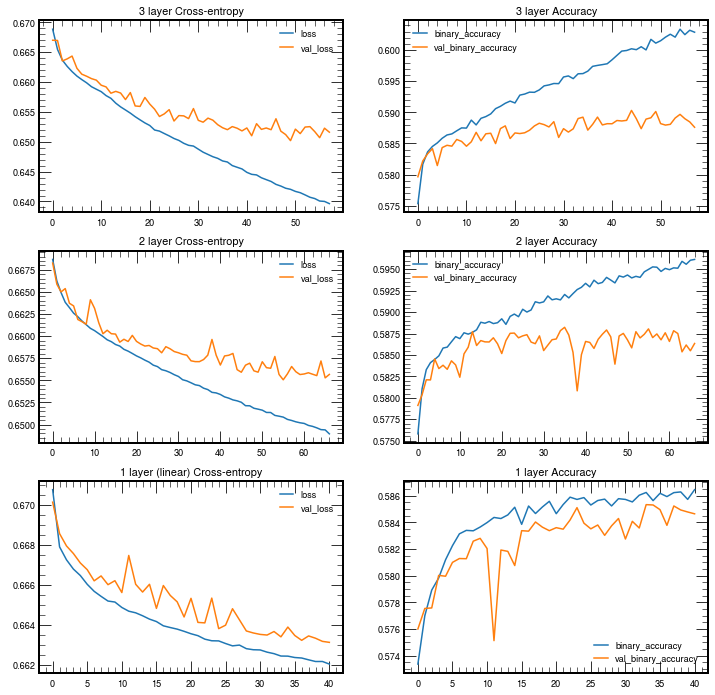

In [104]:
fig, ax = plt.subplots(3,2)
history_df1.loc[:, ['loss', 'val_loss']].plot(title="3 layer Cross-entropy", ax=ax[0][0])
history_df1.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot(title="3 layer Accuracy", ax=ax[0][1])
history_df2.loc[:, ['loss', 'val_loss']].plot(title="2 layer Cross-entropy", ax=ax[1][0])
history_df2.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot(title="2 layer Accuracy", ax=ax[1][1])
history_df3.loc[:, ['loss', 'val_loss']].plot(title="1 layer (linear) Cross-entropy", ax=ax[2][0])
history_df3.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot(title="1 layer Accuracy", ax=ax[2][1])
# ax[0].set_xlabel('epochs')
# ax[1].set_xlabel('epochs')
plt.show()

In [137]:
from sklearn.metrics import confusion_matrix
threshold=0.5
# for threshold in (0.4,0.45,0.5):
y_pred1 = (model1.predict(val_X)>= threshold).astype(int)
y_pred2 = (model2.predict(val_X)>= threshold).astype(int)
y_pred3 = (model3.predict(val_X)>= threshold).astype(int)
cm1 = (confusion_matrix(val_y, y_pred1)/len(y_pred1))*100
cm2 = (confusion_matrix(val_y, y_pred2)/len(y_pred2))*100
cm3 = (confusion_matrix(val_y, y_pred3)/len(y_pred3))*100

In [138]:
print(cm1)
print(cm2) 
print(cm3)

[[40.7125   9.25125]
 [32.01    18.02625]]
[[40.43     9.53375]
 [31.73    18.30625]]
[[40.2      9.76375]
 [32.635   17.40125]]


In [106]:
y_preds1 = model1.predict(val_X).ravel()
y_preds2 = model2.predict(val_X).ravel()
y_preds3 = model3.predict(val_X).ravel()
# print(y_preds)

In [107]:
from sklearn.metrics import roc_curve
fpr1, tpr1, thresholds1 = roc_curve(val_y, y_preds1)
fpr2, tpr2, thresholds2 = roc_curve(val_y, y_preds2)
fpr3, tpr3, thresholds3 = roc_curve(val_y, y_preds3)

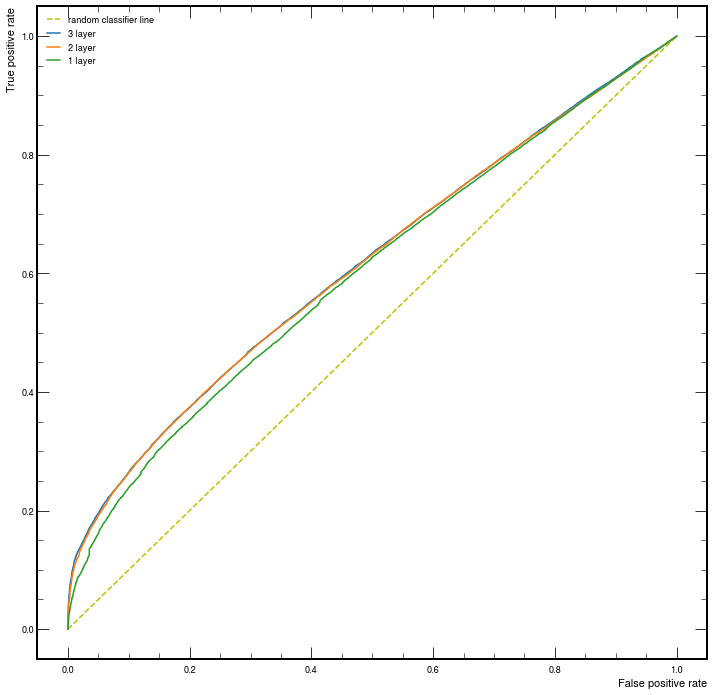

In [111]:
plt.figure(1)
plt.plot([0,1], [0,1], 'y--', label='random classifier line')
plt.plot(fpr1, tpr1, label='3 layer')
plt.plot(fpr2, tpr2, label='2 layer')
plt.plot(fpr3, tpr3, label='1 layer')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend()
plt.show()

In [117]:
from sklearn.metrics import auc
auc1 = auc(fpr1, tpr1)
auc2 = auc(fpr2, tpr2)
auc3 = auc(fpr3, tpr3)


In [119]:
print(f"For 3 layers, area under the curve is {auc1}")
print(f"For 2 layers, area under the curve is {auc2}")
print(f"For 1 layer, area under the curve is {auc3}")


For 3 layers, area under the curve is 0.6140833487150601
For 2 layers, area under the curve is 0.6127690077117096
For 1 layer, area under the curve is 0.6010952253256778


In [121]:
i1 =np.arange(len(tpr1))
i2 =np.arange(len(tpr2))
i3 =np.arange(len(tpr3))

In [123]:
roc1 = pd.DataFrame({'tf': pd.Series(tpr1-(1-fpr1), index=i1), 'thresholds': pd.Series(thresholds1, index=i1)})
roc2 = pd.DataFrame({'tf': pd.Series(tpr2-(1-fpr2), index=i2), 'thresholds': pd.Series(thresholds2, index=i2)})
roc3 = pd.DataFrame({'tf': pd.Series(tpr3-(1-fpr3), index=i3), 'thresholds': pd.Series(thresholds3, index=i3)})


In [131]:
ideal_roc1 = roc1.iloc[(roc.tf-0).abs().argsort()[:1]]
ideal_roc2 = roc2.iloc[(roc.tf-0).abs().argsort()[:1]]
ideal_roc3 = roc3.iloc[(roc.tf-0).abs().argsort()[:1]]

In [133]:
print(f'Ideal threshold with 3 layers: {ideal_roc1.thresholds}')
print(f'Ideal threshold with 2 layers: {ideal_roc2.thresholds}')
print(f'Ideal threshold with 1 layer: {ideal_roc3.thresholds}')

Ideal threshold with 3 layers: 18422    0.437997
Name: thresholds, dtype: float32
Ideal threshold with 2 layers: 18422    0.439409
Name: thresholds, dtype: float32
Ideal threshold with 1 layer: 18422    0.44383
Name: thresholds, dtype: float32


## Testing number in each layer

We can see from previous that 3 layers seems to be the most effective.

In [139]:
model512 = keras.Sequential([
    layers.Dense(512, activation='relu', input_shape=input_shape),
    layers.Dense(512, activation='relu'),
    layers.Dense(512, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])
model512.compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_accuracy'])

early_stopping=keras.callbacks.EarlyStopping(
    patience=40,
    min_delta=0.01,
    restore_best_weights=True,
)
history512 = model512.fit(train_X,train_y,validation_data=(val_X, val_y), batch_size=256, epochs=200, callbacks=[early_stopping], verbose=0, use_multiprocessing=True )
history_df512 = pd.DataFrame(history512.history)
history_df512.head()

,loss,binary_accuracy,val_loss,val_binary_accuracy
0,0.668891,0.574575,0.667447,0.580850
1,0.666240,0.580509,0.667435,0.579225
2,0.664289,0.582313,0.667889,0.573488
3,0.663430,0.584147,0.663340,0.583212
4,0.662135,0.585634,0.665107,0.580525


In [150]:
model.save('./models/model512.h5')

In [140]:
model256 = keras.Sequential([
    layers.Dense(256, activation='relu', input_shape=input_shape),
    layers.Dense(256, activation='relu'),
    layers.Dense(256, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])
model256.compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_accuracy'])

early_stopping=keras.callbacks.EarlyStopping(
    patience=40,
    min_delta=0.01,
    restore_best_weights=True,
)
history256 = model256.fit(train_X,train_y,validation_data=(val_X, val_y), batch_size=256, epochs=200, callbacks=[early_stopping], verbose=0, use_multiprocessing=True )
history_df256 = pd.DataFrame(history256.history)
history_df256.head()

model.save('./models/model256.h5')

,loss,binary_accuracy,val_loss,val_binary_accuracy
0,0.668410,0.576822,0.666827,0.580787
1,0.665298,0.582006,0.665748,0.581950
2,0.663920,0.583491,0.662891,0.583750
3,0.662717,0.584550,0.663059,0.583050
4,0.661923,0.585428,0.662429,0.584288


In [141]:
model128 = keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=input_shape),
    layers.Dense(128, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])
model128.compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_accuracy'])

early_stopping=keras.callbacks.EarlyStopping(
    patience=40,
    min_delta=0.01,
    restore_best_weights=True,
)
history128 = model128.fit(train_X,train_y,validation_data=(val_X, val_y), batch_size=128, epochs=200, callbacks=[early_stopping], verbose=0, use_multiprocessing=True )
history_df128 = pd.DataFrame(history128.history)
history_df128.head()

,loss,binary_accuracy,val_loss,val_binary_accuracy
0,0.668706,0.576791,0.666962,0.580575
1,0.665727,0.580997,0.665134,0.582725
2,0.663776,0.583594,0.662890,0.583737
3,0.662709,0.584966,0.665068,0.582575
4,0.661913,0.584922,0.662023,0.584000


In [152]:
model.save('./models/model128.h5')

In [142]:
model64 = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=input_shape),
    layers.Dense(64, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])
model64.compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_accuracy'])

early_stopping=keras.callbacks.EarlyStopping(
    patience=40,
    min_delta=0.01,
    restore_best_weights=True,
)
history64 = model64.fit(train_X,train_y,validation_data=(val_X, val_y), batch_size=64, epochs=200, callbacks=[early_stopping], verbose=0, use_multiprocessing=True )
history_df64 = pd.DataFrame(history64.history)
history_df64.head()

,loss,binary_accuracy,val_loss,val_binary_accuracy
0,0.668636,0.575625,0.667782,0.578987
1,0.666030,0.580163,0.664987,0.582125
2,0.664568,0.582975,0.666579,0.582775
3,0.663323,0.583778,0.663228,0.582738
4,0.662454,0.584400,0.662349,0.584100


In [153]:
model.save('./models/model64.h5')

In [143]:
model32 = keras.Sequential([
    layers.Dense(32, activation='relu', input_shape=input_shape),
    layers.Dense(32, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])
model32.compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_accuracy'])

early_stopping=keras.callbacks.EarlyStopping(
    patience=40,
    min_delta=0.01,
    restore_best_weights=True,
)
history32 = model32.fit(train_X,train_y,validation_data=(val_X, val_y), batch_size=32, epochs=200, callbacks=[early_stopping], verbose=0, use_multiprocessing=True )
history_df32 = pd.DataFrame(history32.history)
history_df32.head()

,loss,binary_accuracy,val_loss,val_binary_accuracy
0,0.669329,0.573569,0.668981,0.576338
1,0.667517,0.576803,0.667538,0.578575
2,0.666482,0.578737,0.667728,0.578862
3,0.664530,0.582512,0.664305,0.582838
4,0.663759,0.583434,0.665473,0.579975


In [154]:
model.save('./models/model32.h5')

In [144]:
y_preds512 = model512.predict(val_X).ravel()
y_preds256 = model256.predict(val_X).ravel()
y_preds128 = model128.predict(val_X).ravel()
y_preds64 = model64.predict(val_X).ravel()
y_preds32 = model32.predict(val_X).ravel()

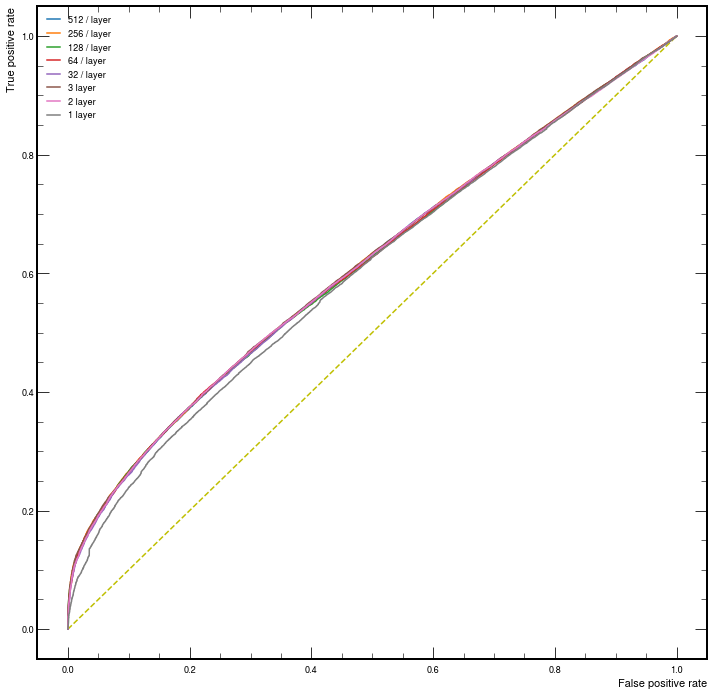

For 512 / layer, area under the curve is 0.6125188400802153
For 256 / layer, area under the curve is 0.6137680316743217
For 128 / layer, area under the curve is 0.6115587039505437
For 64 / layer, area under the curve is 0.6120716126576413
For 32 / layer, area under the curve is 0.6119677919780706


In [156]:
from sklearn.metrics import roc_curve
fpr512, tpr512, thresholds1 = roc_curve(val_y, y_preds512)
fpr256, tpr256, thresholds1 = roc_curve(val_y, y_preds256)
fpr128, tpr128, thresholds1 = roc_curve(val_y, y_preds128)
fpr64, tpr64, thresholds1 = roc_curve(val_y, y_preds64)
fpr32, tpr32, thresholds1 = roc_curve(val_y, y_preds32)

plt.figure(1)
plt.plot([0,1], [0,1], 'y--' )
plt.plot(fpr512, tpr512, label='512 / layer')
plt.plot(fpr256, tpr256, label='256 / layer')
plt.plot(fpr128, tpr128, label='128 / layer')
plt.plot(fpr64, tpr64, label='64 / layer')
plt.plot(fpr32, tpr32, label='32 / layer')
plt.plot(fpr1, tpr1, label='3 layer')
plt.plot(fpr2, tpr2, label='2 layer')
plt.plot(fpr3, tpr3, label='1 layer')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend()
plt.show()

from sklearn.metrics import auc
auc512 = auc(fpr512, tpr512)
auc256 = auc(fpr256, tpr256)
auc128 = auc(fpr128, tpr128)
auc64 = auc(fpr64, tpr64)
auc32 = auc(fpr32, tpr32)

print(f"For 512 / layer, area under the curve is {auc512}")
print(f"For 256 / layer, area under the curve is {auc256}")
print(f"For 128 / layer, area under the curve is {auc128}")
print(f"For 64 / layer, area under the curve is {auc64}")
print(f"For 32 / layer, area under the curve is {auc32}")


### Mixed layers

Now see compare 256 / layer with decrease and increase with layers. 

In [39]:
model256 = keras.models.load_model('./models/model256.h5')

2022-02-14 12:01:51.253336: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib/:/home/craig/.local/lib/:/home/craig/Downloads/MG5_aMC_v3_2_0/HEPTools/lhapdf6_py3/lib/
2022-02-14 12:01:51.253356: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-02-14 12:01:51.253370: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (craig-manjaroboi): /proc/driver/nvidia/version does not exist
2022-02-14 12:01:51.253769: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compile

In [40]:
modeld = keras.Sequential([
    layers.Dense(256, activation='relu', input_shape=input_shape),
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])
modeld.compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_accuracy'])

early_stopping=keras.callbacks.EarlyStopping(
    patience=40,
    min_delta=0.01,
    restore_best_weights=True,
)
historyd = modeld.fit(train_X,train_y,validation_data=(val_X, val_y), batch_size=64, epochs=200, callbacks=[early_stopping], verbose=0, use_multiprocessing=True )
history_dfd = pd.DataFrame(historyd.history)
history_dfd.head()

,loss,binary_accuracy,val_loss,val_binary_accuracy
0,0.669256,0.575372,0.667720,0.574387
1,0.667479,0.579244,0.668511,0.570787
2,0.666124,0.581153,0.664705,0.579125
3,0.664653,0.582141,0.663811,0.580350
4,0.663660,0.583234,0.663129,0.582937


In [42]:
modeld.save('./models/descend.h5')

In [43]:
modela = keras.Sequential([
    layers.Dense(256, activation='relu', input_shape=input_shape),
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])
modela.compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_accuracy'])

early_stopping=keras.callbacks.EarlyStopping(
    patience=40,
    min_delta=0.01,
    restore_best_weights=True,
)
historya = modela.fit(train_X,train_y,validation_data=(val_X, val_y), batch_size=64, epochs=200, callbacks=[early_stopping], verbose=0, use_multiprocessing=True )
history_dfa = pd.DataFrame(historya.history)
history_dfa.head()

,loss,binary_accuracy,val_loss,val_binary_accuracy
0,0.669416,0.574800,0.669733,0.573925
1,0.667822,0.577534,0.667906,0.572438
2,0.666784,0.579178,0.665785,0.579575
3,0.665488,0.581475,0.665805,0.579700
4,0.664308,0.582216,0.663227,0.580612


In [44]:
modela.save('./models/ascend.h5')

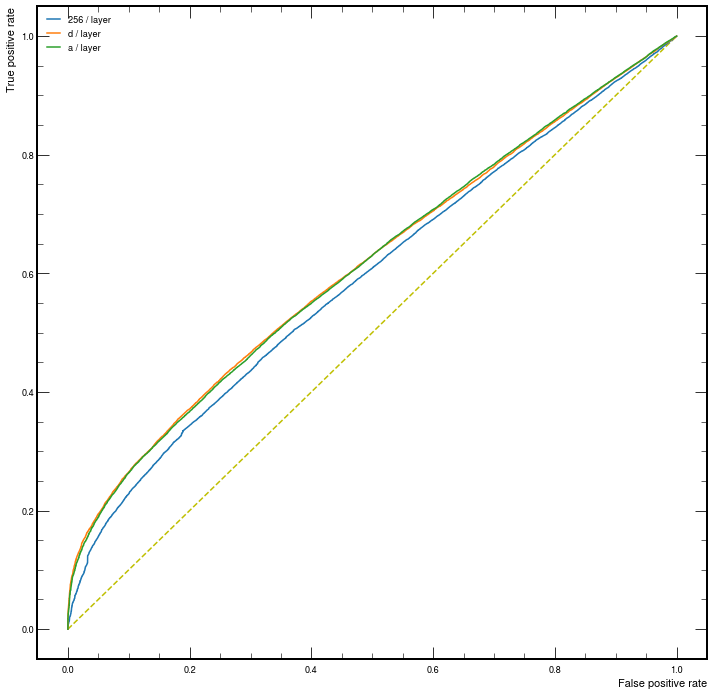

For 256 / layer, area under the curve is 0.5906786274396701
For descending / layer, area under the curve is 0.6114009466564734
For ascending / layer, area under the curve is 0.6108271255455383


In [46]:
y_preds256 = model256.predict(val_X).ravel()
y_predsd = modeld.predict(val_X).ravel()
y_predsa = modela.predict(val_X).ravel()

from sklearn.metrics import roc_curve
fpr256, tpr256, thresholds256 = roc_curve(val_y, y_preds256)
fprd, tprd, thresholdsd = roc_curve(val_y, y_predsd)
fpra, tpra, thresholdsa = roc_curve(val_y, y_predsa)

plt.figure(1)
plt.plot([0,1], [0,1], 'y--' )
plt.plot(fpr256, tpr256, label='256 / layer')
plt.plot(fprd, tprd, label='d / layer')
plt.plot(fpra, tpra, label='a / layer')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend()
plt.show()

from sklearn.metrics import auc
auc256 = auc(fpr256, tpr256)
aucd = auc(fprd, tprd)
auca = auc(fpra, tpra)

print(f"For 256 / layer, area under the curve is {auc256}")
print(f"For descending / layer, area under the curve is {aucd}")
print(f"For ascending / layer, area under the curve is {auca}")


We identify that the descending node number seems to have an impact on the AUC.

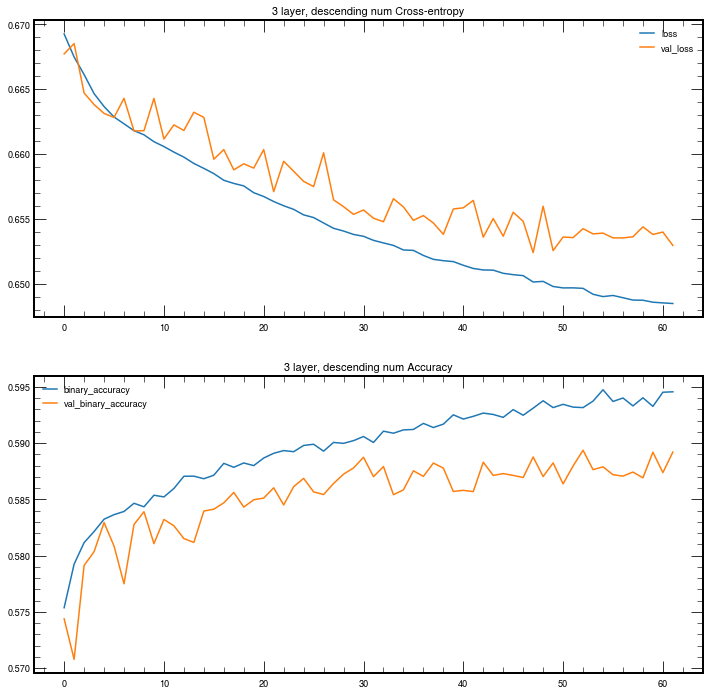

In [49]:
fig, ax = plt.subplots(2,1)
history_dfd.loc[:, ['loss', 'val_loss']].plot(title="3 layer, descending num Cross-entropy", ax=ax[0])
history_dfd.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot(title="3 layer, descending num Accuracy", ax=ax[1])
plt.show()

In [50]:
yd = modeld.predict(val_X)

In [51]:
bins = np.linspace(0,1, 100)

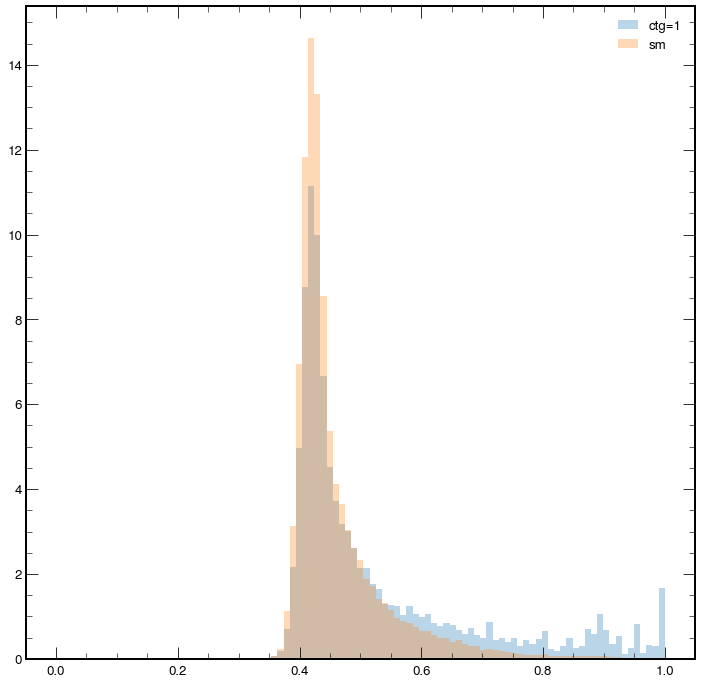

In [54]:
df = pd.DataFrame({'true':np.asarray(val_y).flatten(), 'pred':np.asarray(yd).flatten()})
plt.hist(df.loc[df.true ==1, ['pred']],bins=bins, alpha=0.3, label='ctg=1', density=True)
plt.hist(df.loc[df.true !=1, ['pred']],bins=bins,alpha=0.3, label='sm', density=True)
plt.legend()
plt.show()